# Kredi Kartı Sahteciliği – Modellerin Karşılaştırılması

Bu notebook, aynı temizlenmiş veri seti üzerinde eğitilmiş üç farklı modelin
performansını karşılaştırmak için hazırlanmıştır:

- **Baseline Logistic Regression** (`baseline_logreg`)
- **Random Forest** (`random_forest`)
- **XGBoost** (`xgboost_model`)

Tüm modeller, ortak veri temizleme adımlarından sonra elde edilen
`creditcard_clean.csv` dosyası kullanılarak eğitilmiştir.
Bu nedenle karşılaştırma adil ve tutarlı bir şekilde yapılmaktadır.


In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)

BASE = Path(".").resolve()
reports_dir = BASE / "outputs" / "reports"
reports_dir


WindowsPath('C:/Users/Administrator/Desktop/fraud-detection-win-ar/outputs/reports')

In [2]:
import numpy as np
from pathlib import Path

reports_dir = Path("outputs/reports")

# ----------------------------
# 1) Baseline Logistic Regression
# ----------------------------
baseline_y_test = np.load(reports_dir / "baseline_y_test.npy")
baseline_y_pred = np.load(reports_dir / "baseline_y_pred.npy")
baseline_y_prob = np.load(reports_dir / "baseline_y_prob.npy")

# ----------------------------
# 2) Random Forest
# ----------------------------
rf_y_test = np.load(reports_dir / "random_forest_y_test.npy")
rf_y_pred = np.load(reports_dir / "random_forest_y_pred.npy")
rf_y_prob = np.load(reports_dir / "random_forest_y_prob.npy")

# ----------------------------
# 3) XGBoost
# ----------------------------
xgb_y_test = np.load(reports_dir / "xgboost_y_test.npy")
xgb_y_pred = np.load(reports_dir / "xgboost_y_pred.npy")
xgb_y_prob = np.load(reports_dir / "xgboost_y_prob.npy")

print("Tüm modellerin tahminleri yüklendi ")


Tüm modellerin tahminleri yüklendi 


In [3]:
files = [
    "baseline_logreg_metrics.json",
    "random_forest_metrics.json",
    "xgboost_metrics.json",
    # Eğer ileride eklerseniz:
    # "gradient_boosting_metrics.json",
]

rows = []

for fname in files:
    fpath = reports_dir / fname
    if not fpath.exists():
        print("Dosya bulunamadı, atlanıyor:", fname)
        continue

    with open(fpath, "r", encoding="utf-8") as f:
        data = json.load(f)

    model_name = data.get("model_name", fname.replace("_metrics.json", ""))

    cls_rep = data.get("classification_report", {})
    # Fraud = "1" sınıfı
    fraud_metrics = cls_rep.get("1", {})

    row = {
        "model": model_name,
        "roc_auc": data.get("roc_auc", None),
        "avg_precision": data.get("average_precision", None),
        "fraud_precision": fraud_metrics.get("precision", None),
        "fraud_recall": fraud_metrics.get("recall", None),
        "fraud_f1": fraud_metrics.get("f1-score", None),
    }
    rows.append(row)

df_compare = pd.DataFrame(rows)
df_compare


,model,roc_auc,avg_precision,fraud_precision,fraud_recall,fraud_f1
0,baseline_logreg,0.965663,0.673833,0.854839,0.557895,0.675159
1,random_forest,0.933540,NaN,0.806818,0.747368,0.775956
2,xgboost_model,0.980815,0.825854,0.985915,0.736842,0.843373


In [4]:
df_compare_sorted = df_compare.sort_values(by="fraud_f1", ascending=False)
df_compare_sorted.reset_index(drop=True, inplace=True)
df_compare_sorted


,model,roc_auc,avg_precision,fraud_precision,fraud_recall,fraud_f1
0,xgboost_model,0.980815,0.825854,0.985915,0.736842,0.843373
1,random_forest,0.933540,NaN,0.806818,0.747368,0.775956
2,baseline_logreg,0.965663,0.673833,0.854839,0.557895,0.675159


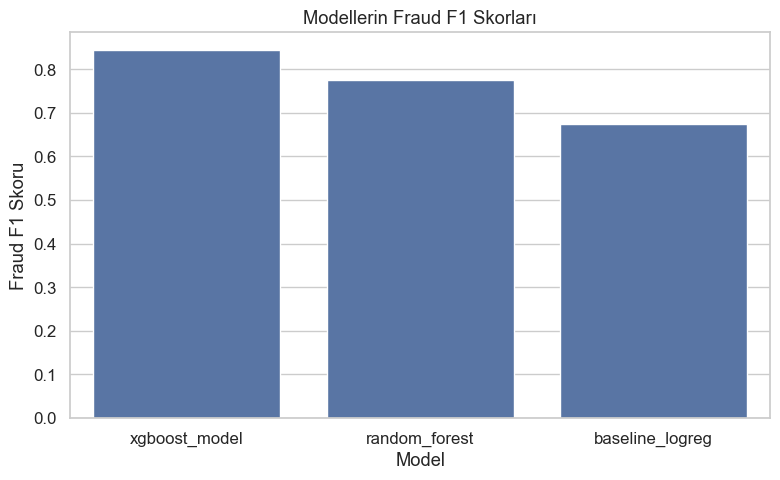

In [5]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_compare_sorted,
    x="model",
    y="fraud_f1"
)
plt.title("Modellerin Fraud F1 Skorları")
plt.xlabel("Model")
plt.ylabel("Fraud F1 Skoru")
plt.tight_layout()
plt.show()


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import pandas as pd
import os

os.makedirs("outputs/figures_compare", exist_ok=True)

# ----------------------------
# 1) Baseline Logistic Regression
# ----------------------------

y_test = baseline_y_test
y_pred = baseline_y_pred
y_prob = baseline_y_prob

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Baseline Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.savefig("outputs/figures_compare/baseline_confusion.png", dpi=300)
plt.close()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.3f}")
plt.title("Baseline Logistic Regression - ROC Curve")
plt.tight_layout()
plt.savefig("outputs/figures_compare/baseline_roc.png", dpi=300)
plt.close()

precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(recall, precision)
plt.title("Baseline Logistic Regression - Precision Recall Curve")
plt.tight_layout()
plt.savefig("outputs/figures_compare/baseline_pr.png", dpi=300)
plt.close()


# ----------------------------
# 2) Random Forest
# ----------------------------

y_test = rf_y_test
y_pred = rf_y_pred
y_prob = rf_y_prob

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.savefig("outputs/figures_compare/random_forest_confusion.png", dpi=300)
plt.close()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.3f}", color="orange")
plt.title("Random Forest - ROC Curve")
plt.tight_layout()
plt.savefig("outputs/figures_compare/random_forest_roc.png", dpi=300)
plt.close()

precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(recall, precision, color="orange")
plt.title("Random Forest - Precision Recall Curve")
plt.tight_layout()
plt.savefig("outputs/figures_compare/random_forest_pr.png", dpi=300)
plt.close()


# ----------------------------
# 3) XGBoost
# ----------------------------

y_test = xgb_y_test
y_pred = xgb_y_pred
y_prob = xgb_y_prob

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples")
plt.title("XGBoost - Confusion Matrix")
plt.tight_layout()
plt.savefig("outputs/figures_compare/xgboost_confusion.png", dpi=300)
plt.close()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.3f}", color="purple")
plt.title("XGBoost - ROC Curve")
plt.tight_layout()
plt.savefig("outputs/figures_compare/xgboost_roc.png", dpi=300)
plt.close()

precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(recall, precision, color="purple")
plt.title("XGBoost - Precision Recall Curve")
plt.tight_layout()
plt.savefig("outputs/figures_compare/xgboost_pr.png", dpi=300)
plt.close()


In [7]:
output_path = reports_dir / "models_comparison_table.csv"
df_compare_sorted.to_csv(output_path, index=False, encoding="utf-8")
print("Karşılaştırma tablosu kaydedildi →", output_path)


Karşılaştırma tablosu kaydedildi → outputs\reports\models_comparison_table.csv


## Modellerin Sayısal Karşılaştırması

Aşağıdaki tabloda, aynı temizlenmiş veri seti üzerinde eğitilmiş üç modelin
özellikle **Fraud (1) sınıfı** için önemli metrikleri özetlenmiştir:

- **ROC-AUC**: Modelin genel ayırt etme gücünü gösterir.
- **Average Precision (PR-AUC)**: Özellikle dengesiz veri setlerinde değerlidir.
- **Fraud Precision / Recall / F1**: Sahtecilik sınıfını ne kadar doğru ve ne kadar kapsamlı yakaladığımızı gösterir.

Tabloya göre:

- **Baseline Logistic Regression (baseline_logreg)** modeli,
  iyi bir başlangıç noktası (baseline) sağlamaktadır; ancak Fraud sınıfı için
  precision ve F1 skorları, diğer modellere göre daha düşüktür.

- **Random Forest** modeli, Fraud sınıfında daha yüksek precision ve tatmin edici
  recall değerleriyle, baseline modele göre belirgin bir iyileşme sunmaktadır.

- **XGBoost** modeli ise hem ROC-AUC hem de Fraud F1 skoru açısından
  projedeki en güçlü model olarak öne çıkmaktadır.
  Hem normal (0) hem de sahte (1) işlemleri ayırt etme gücü yüksektir.

Bu nedenle, nihai sonuç açısından XGBoost en başarılı model olarak seçilmiş,
Random Forest ikinci güçlü alternatif, Logistic Regression ise
karşılaştırma için referans (baseline) model olarak değerlendirilmiştir.
